## Notebook for Figure 2 and related content: Correlations genes-ephys in beta-cells and pathway analysis
### Author: J. Camunas-Soler
### Last Updated: Feb. 2020

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
%matplotlib inline
from singlet.dataset import Dataset
from singlet import SampleSheet, CountsTable
import matplotlib.patches as mpatches

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
%run ./../functions/helper_functions.py
%run ./../functions/predictions.py

#### Load Data and definitions

In [4]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total Exocitosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [5]:
root_folder = './../data/'
analysis_folder = './../analysis/'
resources_folder= './../resources/'
fig_folder = './../figures/fig2_suppfig3/'
correlations_folder = analysis_folder +'correlations_betacell/beta_correlations_all/beta_ND'
folder_gsea_sum = analysis_folder +'/GSEA_betacell/grouped'

In [6]:
#Load and reformat patch-seq dataset
filename =  root_folder + 'patchclamp_wcryo_human.counts.tab'
metadata = root_folder + 'patchclamp_wcryo_human.metadata.tab'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv(analysis_folder + 'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder +'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')

annotation.rename(columns=dict_phenotype_norm, inplace=True)
#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

#remove genes not seen in 5 cells or having 10 counts total
test= filter_genes_pp(test, min_cells=5, min_counts=10)
#create dataset
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
#remove nans in glucse
ds.samplesheet = ds.samplesheet[~ds.samplesheet[['Glucose_mM']].isnull().values]
#save unnormalized table
ds_pclamp_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_norm = ds.copy()
ds_norm.counts = ds_norm.counts.normalize()
ds_norm.counts.pseudocount = 1
ds_norm.counts = ds_norm.counts.log(base=2)
ds_norm.counts.pseudocount = 1
ds_norm_pclamp = ds_norm.copy()

filter_condition = {'Cryopreserved': ['Yes']}
ds_t1d = filter_samplesheet(ds_norm, filter_dict= filter_condition)

filter_condition = {'Cryopreserved': ['No']}
ds_pclamp = filter_samplesheet(ds_norm, filter_dict= filter_condition)

#### Fig2a - Plot electrophysiology correlations

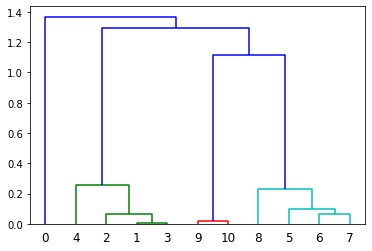

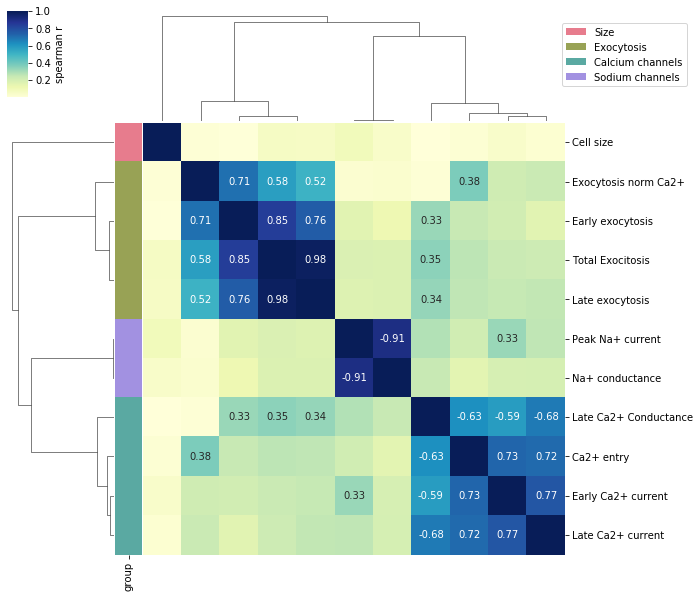

In [7]:
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy'],
                   'Patched': ['Yes'],
                    'Glucose_mM': [5,10],
                    'TimefromDispersion_days': [1,2,3,4],
                              'preincubation': ['No', 'Yes']}

filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)
#where to output figures and plot names
folder_output_figs = '/Users/joan/Desktop/FIG2/'
plots_ID = 'beta_cell_main'

ephys_dict= {'Size': ['Cell size'],
         'Exocytosis': ['Total Exocitosis','Early exocytosis','Late exocytosis','Exocytosis norm Ca2+'],
         'Calcium channels': ['Ca2+ entry','Early Ca2+ current','Late Ca2+ current','Late Ca2+ Conductance'],
         'Sodium channels'  : ['Peak Na+ current','Na+ conductance']}
ephys_list = []
for key, par in ephys_dict.items():
    ephys_list = ephys_list + par
    
#Calculate correlation
df = filtered_dataset.samplesheet[ephys_list].copy()
#df = df[~(df==0)]
df = df.corr(method='spearman', min_periods=1) #calculate correlation matrix on samples
#keep absolute values and make a copy to label with non signed values
df_wabs = df.copy()
df = df.abs()

lut_gene = make_group_tags(df=df, dict_groups=ephys_dict)

#code to modify ordering of last clustering to make small plots consistent
from scipy.cluster import hierarchy
z = hierarchy.linkage(df, method='average', metric='correlation', optimal_ordering=False)
z2 = hierarchy.dendrogram(z)
reordered_index = z2['leaves']


ds_genetag = pd.DataFrame(index=df.index)
for group, genes in ephys_dict.items():
    for gene in genes:
        if gene in ds_genetag.index:
            ds_genetag.loc[gene,'group'] = group
ds_genetag = ds_genetag[ds_genetag['group'].notnull()]

#make legend
legend_plot = [mpatches.Patch(color=lut_gene[key], label=key) for key in lut_gene]
#add values onny on values higher than 0,3
annot= df_wabs[(df>0.3) & (df<1)].round(2).astype(str).replace({'nan':''})
annot = annot.iloc[reordered_index, reordered_index]

#plot
g =sns.clustermap(data=df,
                  row_linkage=z,
                  col_linkage=z,
               row_colors=ds_genetag['group'].map(lut_gene) , 
                   yticklabels=1,
               cmap='YlGnBu',
                 metric='correlation',
                 annot=annot,fmt = '',
                 xticklabels='',
                 cbar_kws={'label':'spearman r'})

#labels for gene groups
for key, color in lut_gene.items():
    g.ax_col_dendrogram.bar(0, 0, color=lut_gene[key],
                            label=key, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="right", ncol=1, bbox_to_anchor=(1.3,0.6))
g.savefig(fig_folder +'Fig2A.pdf',dpi=300)

#### Fig 2b - Plot heatmap of correlations beta cells

In [8]:
import itertools
cell_types = ['beta']
diseases = ['healthy']
n_cells_smooth = 40
qlow=.03
qhigh=0.97
floor_value = 0.5
par = 'Total Exocitosis'

#select genes that passes the selection threshold of being 2 SD away from zero as calculated in supporting notebooks
dir_beta = correlations_folder 

results_corr = import_correlations_folder(dir_name=dir_beta,
                          substring_pattern='beta_healthy_(.+?)_10')

cond1 = results_corr['Total Exocitosis'].loc[:,'pct cells'] > 50
cond2 = np.abs(results_corr['Total Exocitosis'].loc[:,'zscore_raw_mean']) >2.
genelist  = results_corr['Total Exocitosis'][cond1 & cond2].index.values


filter_condition = {'cell_type': cell_types, 
                    'DiabetesStatus': diseases,
                   'Patched': ['Yes'],
                    'Glucose_mM': [5,10],
                    'TimefromDispersion_days': [1,2,3,4],
                              'preincubation': ['Yes','No']}

filtered_dataset = filter_samplesheet(ds_norm, filter_dict= filter_condition)
ts = filtered_dataset.copy()

#remove top quantiles of data
ts.samplesheet[par] = filter_quantile_values(ts.samplesheet, columns=par, qlow=qlow,qhigh=qhigh, include_quantiles=True)[par]
#remove all na
reindex_val = ts.samplesheet[par].dropna().index.values
ts.samplesheet = ts.samplesheet.reindex(reindex_val)
#make all electrophysiology parameters in positve axis (flip sign of calcium and sodium currents)
if ts.samplesheet[par].mean() < 0:
    ts.samplesheet[par] = -1*(ts.samplesheet[par])
#clip value of electrophysiology to zero, no negative values
ts.samplesheet[par] = ts.samplesheet[par].clip(lower=0)
#do log plus 0.5
ts.samplesheet[par] = np.log(ts.samplesheet[par].astype(float)+floor_value)

#sort based on electrophysiology
reindex_val = ts.samplesheet[par].sort_values(ascending=False).index.values
ts.samplesheet = ts.samplesheet.reindex(reindex_val)
#keep copy of cells before rolling average to add donor order on top
tsID = ts.copy()
#do rolling window median value (N cells)
ts.counts = ts.counts.rolling(n_cells_smooth,axis=1).mean().dropna(axis=1)
reindex_val = ts.counts.columns.values
ts.samplesheet = ts.samplesheet.reindex(reindex_val)

#just keep genes of interest, make sure list of genes does not contain nans, zeros ###
ts.counts = ts.counts.reindex(genelist)

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


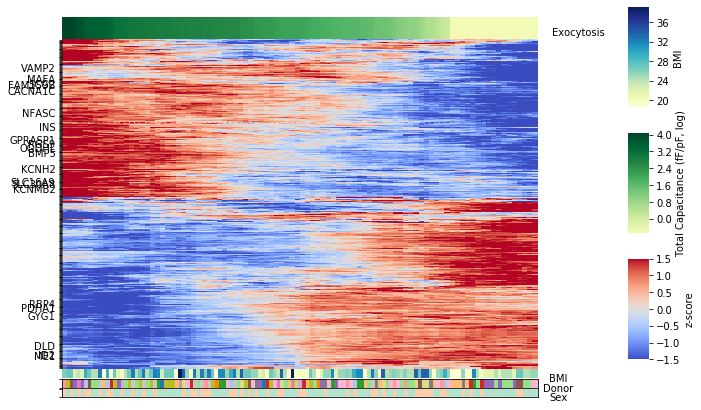

In [9]:
#g.dendrogram_row.reordered_ind
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, leaves_list,optimal_leaf_ordering


ds_plot = ts.copy()
ds_plotID = tsID.copy()
color_phenotypes = ['DonorID','Sex']

#compute linkage and reordered genes for clustering (equivalent to clustermap)
Z = linkage(zscore(ds_plot.counts,axis=1), method='average', metric='euclidean')
reorder_leaves = leaves_list(Z)

df_reord = ds_plot.counts.iloc[reorder_leaves,:].copy()
df_reord = df_reord.apply(lambda x: zscore(x),raw=True,axis=1)

r = df_reord.index.values.copy()
r_for_lines =r.copy()
genestokeep = ['CACNA1C','MAFA','PRKACB','SLC30A8','INS','GYG1','PDHA1','FAM159B','RBP4','ID2','ID3','VAMP2',
               'OGDHL','KCNH2','ABCC9','SCG2','SYN1','KCNMB2','NALCN','ETV1','RFX3','NRXN1','NLGN1','CDH2','NFASC',
               'RGS9','GPRASP1','MRAP2','BMP5','CPT1A','SLC16A9','ME1','DLD']

#keep only the genename in the middle
for i,gene in enumerate(r):  
    if gene not in genestokeep:
        r[i] = ' '
        

        
fig, axs = plt.subplots(5, 2, sharex=False, sharey=False,gridspec_kw = {'height_ratios':[2, 30,0.8,0.8,0.8], 
                                                                        'width_ratios':[15,1], 'hspace':0.01},figsize=(10,7))

axs=axs.flatten()
cbar_ax1 = fig.add_axes([.91, .2, .03, .2])
cbar_ax2 = fig.add_axes([.91, .45, .03, .2])
cbar_ax3 = fig.add_axes([.91, .7, .03, .2])



axs[0] = sns.heatmap(pd.DataFrame(ds_plotID.samplesheet[par]).T,cmap='YlGn',ax=axs[0], center=1.3,
                     cbar_ax=cbar_ax2,xticklabels=False, yticklabels=False,cbar_kws={'label': 'Total Capacitance (fF/pF, log)'})
axs[2] = sns.heatmap(df_reord,cmap='coolwarm',cbar_kws={'label': 'z-score'},ax=axs[2],
                     vmin=-1.5,vmax=1.5,yticklabels=r, xticklabels=False,cbar_ax=cbar_ax1,linewidths=0)

axs[4] = sns.heatmap(pd.DataFrame(ds_plotID.samplesheet['Body mass index (BMI):']).T,cmap='YlGnBu',ax=axs[4],
                     cbar_ax=cbar_ax3,xticklabels=False, yticklabels=False,cbar_kws={'label': 'BMI'},linewidths=0)


data_col = ds_plotID.samplesheet['DonorID']
n = data_col.unique().shape[0]

lut6 = dict(zip(data_col.sort_values().unique(), sns.color_palette('tab20',n)))  

#add bar as an independent heatmap using cbar
axs[6].bar(list(range(0,len(data_col))),np.ones(len(data_col)),color=data_col.map(lut6),width=1,linewidth=0)
axs[6].set_xlim(-0.5,len(data_col)-0.5)
axs[6].axes.set_yticklabels([])
axs[6].axes.get_xaxis().set_visible(False)


data_col = ds_plotID.samplesheet['Sex']
n = data_col.unique().shape[0]

lut6 = dict(zip(data_col.sort_values().unique(), sns.color_palette('Pastel2',n)))  

#add bar as an independent heatmap using cbar
axs[8].bar(list(range(0,len(data_col))),np.ones(len(data_col)),color=data_col.map(lut6),width=1,linewidth=0)
axs[8].set_xlim(-0.5,len(data_col)-0.5)
axs[8].axes.set_yticklabels([])
axs[8].axes.get_xaxis().set_visible(False)
'''short code for adding potential legend, need to be adapted
color = alt55['domain'].map(lut)
for x,y in lut.items():
           plt.bar(0,0,color=y,label=x,width=1)
       plt.legend(bbox_to_anchor=(1.01, 0.95, 1., .102), loc=2,
                  ncol=2, borderaxespad=0.,fontsize=20)'''

axs[0].set_ylabel('Exocytosis',rotation=0,labelpad=40)
axs[0].yaxis.set_label_position("right")
axs[4].set_ylabel('BMI',rotation=0,labelpad=20)
axs[4].yaxis.set_label_position("right")
axs[6].set_ylabel('Donor',rotation=0,labelpad=20)
axs[6].yaxis.set_label_position("right")
axs[8].set_ylabel('Sex',rotation=0,labelpad=20)
axs[8].yaxis.set_label_position("right")


axs[1].remove()
axs[3].remove()
axs[5].remove()
axs[7].remove()
axs[9].remove()

plt.tight_layout()
fig.savefig(fig_folder +'Fig2B.pdf',dpi=300)

#### GSEA summarized per gene group - Supp Fig 3

In [10]:
cols_order_group = {'Cell size': ['Cell size'],
                    'Exocytosis':['Total Exocitosis', 'Late exocytosis', 'Early exocytosis'],
                    'Calcium': ['Ca2+ entry','Early Ca2+ current', 'Late Ca2+ current', 'Late Ca2+ Conductance'],
                    'Sodium': ['Peak Na+ current','Na+ conductance']}

gsea_res_grouped = {}
for i,col in enumerate(cols_order_group):
        with open(folder_gsea_sum + '/beta_healthy_gsea_'  + col + '.pickle', 'rb') as f:
            gsea_res_grouped[col] = pickle.load(f)

In [11]:
### Below with grouped values per pathway
gsea_grouped_summarize = {}
cols_order_group = ['Cell size','Exocytosis','Calcium','Sodium']
for i, col in enumerate(gsea_res_grouped ):
    cond = ((gsea_res_grouped[col]['nes']>0) & (gsea_res_grouped[col]['fdr']<0.2))
    d = gsea_res_grouped [col][cond].loc[:,['nes','fdr','genes']].reset_index()
    d['Electrophysiology'] = col
    gsea_grouped_summarize[col] = d
gsea_summary_table = pd.concat([gsea_grouped_summarize[col] for col in gsea_grouped_summarize])
gsea_summary_table

,Term,nes,fdr,genes,Electrophysiology
0,REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE,2.181886,0.000818,"IDH3A,SDHC,DLD,SDHD,IDH2,ACO2,NNT,SUCLG1,IDH3G...",Cell size
1,REACTOME_PYRUVATE_METABOLISM_AND_CITRIC_ACID_T...,2.111304,0.001227,"PDK4,PDK2,IDH3A,SDHC,DLD,SDHD,IDH2,ACO2,NNT,SU...",Cell size
2,KEGG_CITRATE_CYCLE_TCA_CYCLE,1.925045,0.023714,"IDH3A,SDHC,DLD,SDHD,IDH2,ACO2,ACLY,SUCLG1,IDH3...",Cell size
3,KEGG_PEROXISOME,1.800614,0.094243,"GSTK1,PHYH,ACOX1,PXMP4,HACL1,PEX11B,SLC25A17,D...",Cell size
0,KEGG_CELL_ADHESION_MOLECULES_CAMS,2.119270,0.001495,"NEGR1,NEO1,NLGN1,NFASC,NRXN1,CDH2,CADM1,PTPRM,...",Exocytosis
1,REACTOME_REGULATION_OF_BETA_CELL_DEVELOPMENT,2.209812,0.001495,"MAFA,INS,RBPJ,NKX6-1,INSM1,PAX6,PDX1,AKT3,GCK,...",Exocytosis
2,REACTOME_REGULATION_OF_GENE_EXPRESSION_IN_BETA...,2.079093,0.002740,"MAFA,INS,NKX6-1,PAX6,PDX1,AKT3,GCK,FOXA2,FOXO1...",Exocytosis
3,REACTOME_NEURONAL_SYSTEM,1.780550,0.089085,"KCNH2,DNAJC5,KCNMB2,ABCC9,SYN1,ARHGEF9,CAMK2B,...",Exocytosis
4,REACTOME_ION_CHANNEL_TRANSPORT,1.755942,0.097156,"ATP1B1,ARHGEF9,ATP8A1,ATP2C1,ATP2A2,ATP1B3,ATP...",Exocytosis
5,KEGG_TYPE_II_DIABETES_MELLITUS,1.785199,0.106685,"CACNA1C,MAFA,INS,MAPK10,IRS2,PDX1,GCK,SOCS4,AB...",Exocytosis


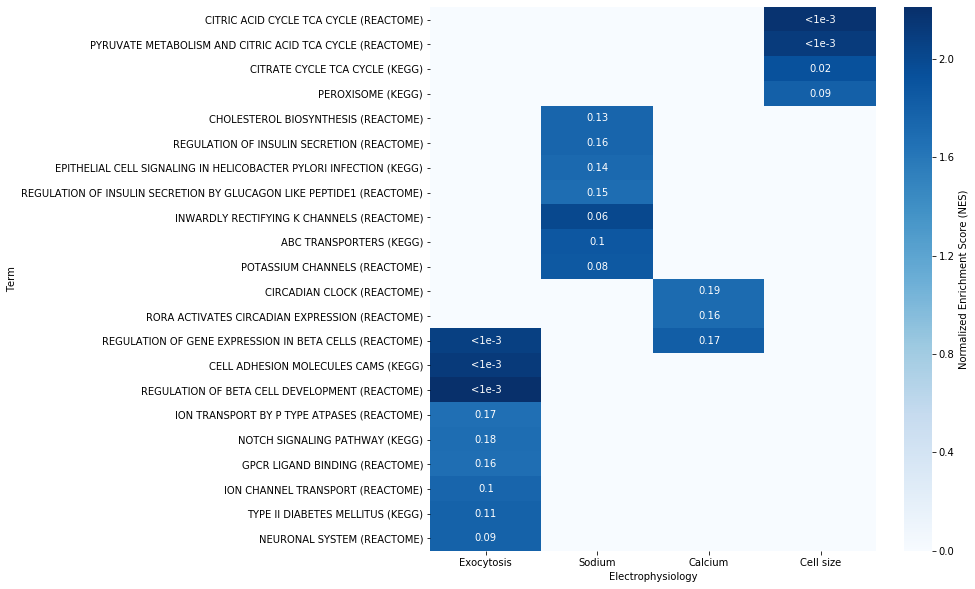

In [12]:
#Plots
s = gsea_summary_table.pivot(index='Electrophysiology',columns='Term', values='nes')
s_lab = gsea_summary_table.pivot(index='Electrophysiology',columns='Term', values='fdr')

s.columns = s.columns.map(lambda x: " ".join(x.split('_')[1:]) + ' (' + x.split('_')[0] + ')' )

f =s.fillna(0).dropna().T.copy()#f = -np.log10(s+s[s>0].min().min()).fillna(0)
s_lab = s_lab.round(2).astype(str).replace({'nan':' ','0.0':'<1e-3'}).T

z_x = hierarchy.linkage(f, method='average', metric='euclidean', optimal_ordering=False)
z_y = hierarchy.linkage(f.T, method='average', metric='euclidean', optimal_ordering=False)
z2_x = hierarchy.dendrogram(z_x, no_plot=True)
z2_y = hierarchy.dendrogram(z_y, no_plot=True)
reordered_index_x = z2_x['leaves']
reordered_index_y = z2_y['leaves']

#reorder and make heatmap
f = f.iloc[reordered_index_x,reordered_index_y]
s_lab = s_lab.iloc[reordered_index_x,reordered_index_y].values
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(f, cmap='Blues',annot=s_lab,fmt='',ax=ax, cbar_kws={'label':'Normalized Enrichment Score (NES)'})
plt.savefig(fig_folder+ 'suppfig3b.pdf')

#### siRNA results

In [13]:
knockdown = pd.read_csv(root_folder+'siRNA_betacell.csv')

In [14]:
#format
knockdown.rename(columns=dict_phenotype_norm, inplace=True)
phenotype_sirna = ['Cell size',
 'Total Exocitosis',
 'Early exocytosis',
 'Late exocytosis',
 'Ca2+ entry',
 'Exocytosis norm Ca2+',
 'Early Ca2+ current',
 'Late Ca2+ Conductance',
 'Reversal potential',
 'Peak Na+ current',
 'Na+ conductance']
#remove commas from data ephys
knockdown[phenotype_sirna] = knockdown[phenotype_sirna].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
knockdown[phenotype_sirna] = knockdown[phenotype_sirna].astype(float)

knockdown['treatment'] = knockdown['treatment'].replace({'siOgdhl':'OGDHL',
                              'siFam159b': 'FAM159B','siRbp4':'RBP4','siRGS9':'RGS9','siGYG1':'GYG1',
                              'siTspan1':'TSPAN1','siPDHA1':'PDHA1','siTSPAN1':'TSPAN1', 'GFP':'GFP'})
#clip Exocytosis to zero
knockdown['Total Exocitosis'] = knockdown['Total Exocitosis'].clip(lower=0)


/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)


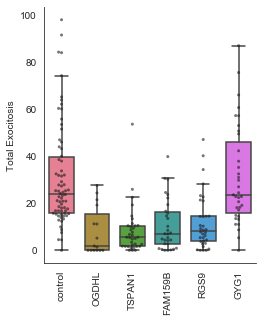

In [15]:
plot_list = ['control','OGDHL','TSPAN1','FAM159B','RGS9','GYG1']
sns.set_style('white')
fig,axs= plt.subplots(nrows=1,ncols=1,figsize=(4,5))

sns.set(font_scale=1.5)
par = 'Total Exocitosis'

sns.boxplot(y=par, data=knockdown, x='treatment', ax=axs, palette='husl', width=0.7,fliersize=0,order=plot_list)
sns.swarmplot(y=par, data=knockdown, x='treatment', ax=axs, color='k',alpha=0.6,size=3,order=plot_list)
axs.set_xlabel(' ')
axs.set_xticklabels(axs.get_xticklabels(),rotation=90)

sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'Fig2E.pdf')

In [16]:
def df_get_mu_pvals_validation(df, 
                               ephys_par =  'Peak Na+ current',
                               tested_genes=['geneA','geneB'], 
                               column_class='treatment',
                               control_name='control'):    
    from scipy.stats import mannwhitneyu
    from scipy.stats import ks_2samp
    from statsmodels.sandbox.stats.multicomp import multipletests
    pvals ={}
    for gene in tested_genes:
        cond1= df[column_class]== control_name
        group1 = df[cond1][ephys_par].dropna()
        cond2= df[column_class]== gene
        group2 = df[cond2][ephys_par].dropna()
        pvals[gene] = mannwhitneyu(group1, group2, use_continuity=True, alternative=None)[1]

        pvals =pd.Series(pvals)
    pvals =pd.DataFrame(pvals,columns=['pval'])
    pvals['FDR']= multipletests(pvals['pval'], method='fdr_bh')[1]
    return pvals

pvals = df_get_mu_pvals_validation(knockdown, 
                        ephys_par = ['Total Exocitosis'],
                        tested_genes= plot_list, 
                        column_class='treatment',
                        control_name='control')
pvals

,pval,FDR
control,4.991686e-01,4.991686e-01
OGDHL,1.018979e-05,1.528468e-05
TSPAN1,2.143136e-11,1.285882e-10
FAM159B,1.285552e-07,2.571104e-07
RGS9,5.972108e-08,1.791632e-07
GYG1,4.674938e-01,4.991686e-01
